# Model Build

In [1]:
# %history -g -f jm_trg.py

In [2]:

import os
import math
import numpy as np
from typing import Any
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
import metrics
from pandas import DataFrame
from metrics import plot_confusion
from IPython.display import Image
from tensorflow.keras import models
from keras.utils import plot_model
from tqdm.notebook import trange
from tensorflow.keras.layers import Dense, Input, Layer, InputSpec, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import (
                f1_score, accuracy_score, precision_score, recall_score)
from data import load_data
from wordcloud import WordCloud
import seaborn as sns
import umap

In [3]:
from sklearn.metrics import pairwise
def pairwise_sqd_distance(X, batch_size):
    return pairwise.pairwise_distances(X, metric='sqeuclidean')

    tiled = tf.tile(tf.expand_dims(X, axis=1), tf.stack([1, batch_size, 1]))
    tiled_trans = tf.transpose(tiled, perm=[1,0,2])
    diffs = tiled - tiled_trans
    sqd_dist_mat = tf.reduce_sum(tf.square(diffs), axis=2)

    return sqd_dist_mat

def make_q(z, batch_size, alpha):

    sqd_dist_mat = np.float32(pairwise_sqd_distance(z, batch_size))
    q = tf.pow((1 + sqd_dist_mat/alpha), -(alpha+1)/2)
    q = tf.linalg.set_diag(q, tf.zeros(shape=[batch_size]))
    q = q / tf.reduce_sum(q, axis=0, keepdims=True)
    # q = 0.5*(q + tf.transpose(q))
    q = tf.clip_by_value(q, 1e-10, 1.0)
    
    return q

In [4]:
from linear_assignment import linear_assignment

def cluster_acc(y_true, y_pred, y_pred_cluster):
    y_true = y_true.astype(np.int64)
    assert y_pred_cluster.size == y_true.size
    D = max(y_pred_cluster.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred_cluster.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    c_loss = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred_cluster.size
    print(f"Cluster Loss {c_loss} on {y_pred_cluster.size} clusters")
    return c_loss

In [5]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn import mixture
from scipy.stats import multivariate_normal

def do_clustering(
        clustering: str, n_clusters: int, z_state: DataFrame, params={}):
    """
    Perform clustering on the data.
        -clustering: the clustering algorithm to use
        -n_clusters: the number of clusters to use
        -z_state: the data to cluster
        -params: dict, optional
            'eps' or 'min_samples' values for DBSCAN/OPTICS
    Returns:
        - the cluster assignments
        - cluster centers
    """
    dbscan_eps = 1
    dbscan_min_samples = 5
    
    if 'eps' in params:
        dbscan_eps = params['eps']
    if 'min_samples' in params:
        dbscan_min_samples = params['min_samples']

    if clustering == 'GMM':
        gmix = mixture.GaussianMixture(
                        n_components=n_clusters,
                        covariance_type='full',
                        verbose=2)
        gmix.fit(z_state)
        y_pred = gmix.predict(z_state)
        # get centres
        centers = np.empty(shape=(gmix.n_components, z_state.shape[1]))
        for i in range(gmix.n_components):
            density = multivariate_normal(
                cov=gmix.covariances_[i],
                mean=gmix.means_[i]).logpdf(z_state)
            centers[i, :] = z_state[np.argmax(density)]
    elif clustering == 'Kmeans':
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)
        y_pred = kmeans.fit_predict(z_state)
        centers = kmeans.cluster_centers_
    elif clustering == 'DBSCAN':
        dbscan = DBSCAN(
            eps=dbscan_eps,
            min_samples=dbscan_min_samples,
            metric='manhattan')
        y_pred = dbscan.fit_predict(z_state)
        centers = None
    elif clustering == 'OPTICS':
        optics = OPTICS(min_samples=dbscan_min_samples)
        y_pred = optics.fit_predict(z_state)
        centers = None
    elif clustering=="agg":
        agg = AgglomerativeClustering(n_clusters=n_clusters, affinity='manhattan', linkage='average')
        y_pred = agg.fit_predict(z_state)
        centers = None
    else:
        raise ValueError('Clustering algorithm not specified/unknown.')

    return y_pred, centers

In [6]:
def freqs_descending(df, col):
    uniques, counts = np.unique(df[col], return_counts=True)
    freq_list = np.asarray((uniques, counts)).T
    freq_list2 =  np.asarray(sorted(freq_list, key=lambda x: -x[1]))
    # purity
    y_true_this_cluster = len(
            df[df[col]==freq_list2[0][0]])
    frac = y_true_this_cluster/len(df)
    return freq_list2, frac

In [7]:
# write_messages.py

from jinja2 import Environment, FileSystemLoader
from pathlib import Path

def write_results_page(clusters, new_clusters, save_dir, test_name, scores):
    
    environment = Environment(loader=FileSystemLoader("templates/"))
    template = environment.get_template("index.jinja")

    results_filename = os.path.join(save_dir, "index.html")
    results_template = environment.get_template("index.jinja")
    context = {
        "clusters": clusters,
        "new_clusters": new_clusters,
        "test_name": test_name,
        "metrics": scores,
    }
    with open(results_filename, mode="w", encoding="utf-8") as results:
        results.write(results_template.render(context))
        full_filename = Path(results_filename).absolute()
        print (f'... wrote results  <a href="{full_filename}">{full_filename}</a>')

In [8]:
from ast import NamedExpr


def show_wordcloud(
    i: int,
    freqs: np.ndarray,
    frac: float,
    name: str,
    filepath: str,
    n: int,
    width: int=16,
    save_only: bool=False)-> None:
    """
    Show wordcloud for a cluster.
    """
    if len(freqs) > 0:
        wc = WordCloud(width=800, height=500).generate_from_frequencies(freqs)
        if not save_only:
            plt.figure(figsize=(width, width-1))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.show()
        wc.to_file(filepath)
    else:
        print(f"No words for cluster {name}")

In [9]:
from pickletools import optimize
from tabnanny import verbose
from unicodedata import name
import warnings
warnings.filterwarnings("ignore")

ENTITY_FILTER_LIST = ['GPE', 'PERSON', 'ORG', 'DATE', 'NORP',
                      'TIME', 'PERCENT', 'LOC', 'QUANTITY', 'MONEY', 'FAC', 'CARDINAL',
                      'EVENT', 'PRODUCT', 'WORK_OF_ART', 'ORDINAL', 'LANGUAGE']


class DeepLatentCluster():

    def __init__(
        self,
        run_name: str,
        config: dict = None,
        verbose: int = 1,
    ):

        self.x = None
        self.y = None
        self.mapping = None
        self.strings = None
        self.y_pred_last = None
        self.input_dim = 768
        self.batch_size = 256

        self.run_name = run_name
        self.model = None
        self.encoder = None
        self.autoencoder = None
        self.save_dir = None
        self.verbose = verbose

        # latent model config
        self.config = {
            "layers_ae": [
                {"n": 500, "act": None},
                {"n": 500, "act": None},
                {"n": 2000, "act": None},
            ],
            "layer_ae_latent":
                {"n": 40, "act": None},
            "layers_latent_network": [
                {"n": 2000, "act": None},
                {"n": 500, "act": None},
                {"n": 500, "act": None},
            ],
            "output_fn": 'sigmoid',
            "opt": k.optimizers.Adam(
                lr=0.001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=None,
                decay=0.0,
                amsgrad=False),
            "loss": k.losses.binary_crossentropy,
            "train_size": 10000,
            "num_clusters": 25,
            "cluster": "GMM",
            "entities": None,
            "entity_count": 10,
            "loss_weights": None,
            "latent_weight": 0.0001,
            "reconstr_weight": 1.0,
            "max_iter": 8000,
            "pretrain_epochs": 300,
            "emb_size": 768,
            "alpha1": 20,
            "alpha2": 1,
            "ae_init_fn": VarianceScaling(
                mode='fan_in',
                scale=1. / 3.,
                distribution='uniform')
        }
        if config is not None:
            self.config = {**self.config, **config}
        if self.config['entities'] is not None and self.config['entity_count'] > 0:
            raise ValueError(
                'entities and entity_count cannot both be specified')
        if self.config['entities'] is None:
            if self.config['entity_count'] == 0:
                self.config['entities'] = ENTITY_FILTER_LIST
            else:
                self.config['entities'] = ENTITY_FILTER_LIST[
                    :self.config['entity_count']]

    def output(self, s: str) -> None:
        if self.verbose > 0:
            print(s)

    def make_data(self, oversample: bool = True, train: bool=True) -> None:

        self.output("Load Data")
        self.x, self.y, self.mapping, self.strings = load_data(
            self.config['train_size'],
            entity_filter=self.config['entities'],
            get_text=True,
            oversample=oversample,
            verbose=self.verbose,
            train=train)
        self.input_dim = self.x.shape[1]
        self.output("Data Loaded")

    # create a Dense layer from a config
    @staticmethod
    def create_layer(config: dict, name: str, init_fn: str = 'glorot_uniform') -> Dense:
        """
        Create a layer from a config dictionary.
        - config: dictionary of layer parameters
            - n: number of units
            - act: activation function
        """
        print(f"Layer {name}: {config['n']} "
              f"activation={config['act']}")
        return Dense(
            name=name,
            units=config["n"],
            activation=config["act"],
            kernel_initializer=init_fn,
            kernel_regularizer='l1')

    # build the autoencoder

    def autoencoder_model(self, layer_specs: list, act: str = 'tanh', init_fn: str = 'glorot_uniform', verbose=0):
        """
        Creates the autoencoder given
        -layer_specs: list of layer sizes.
            Model is symmetrical so only need to specify the first half.
        -act: activation function for hidden layers
        -init_fn: initializer for weights

        returns:
            - the full autoencoder
            - the encoder only
        """
        layers = len(layer_specs) - 1
        # input
        input_img = Input(shape=(layer_specs[0],), name='input')
        x = input_img
        encoder = [input_img]
        # hidden layers in encoder
        for i in range(layers-1):
            layer = Dense(
                layer_specs[i + 1],
                activation=act,
                kernel_initializer=init_fn,
                name=f'encoder_{i}')(encoder[-1])
            encoder += [layer]
            if verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i+1]} '
                      f'activation={act}')

        # latent layer
        latent = Dense(
            layer_specs[-1],
            kernel_initializer=init_fn,
            name=f'encoder_{layers - 1}')(encoder[-1])
        encoder += [latent]
        if verbose >= 2:
            print(f'encoder_{layers - 1}: {layer_specs[-1]}')

        autoencoder = [encoder[-1]]
        # hidden layers in decoder
        for i in range(layers-1, 0, -1):
            layer = Dense(
                layer_specs[i],
                activation=act,
                kernel_initializer=init_fn,
                name=f'decoder_{i}')(autoencoder[-1])
            autoencoder += [layer]
            if verbose >= 2:
                print(f'encoder_{i}: {layer_specs[i]}'
                      f' activation={act}')

        # output
        layer = Dense(
            layer_specs[0],
            kernel_initializer=init_fn,
            name='decoder_0')(autoencoder[-1])
        autoencoder += [layer]
        if verbose >= 2:
            print(f'output: {layer_specs[0]}'
                  f'')
        return (encoder, autoencoder)

    # create the latent_space model

    def create_latent_space_model(self, input_layer: Dense) -> Model:
        """
        Create the model for the latent space
        - input_layer: previous model output layer
        """
        # build ml, the array of layers
        ml = [input_layer]
        layers = self.config['layers_latent_network']
        for n, l in enumerate(layers):
            ml.append(self.create_layer(l, f"latent_{n}")(ml[-1]))

        out_config = {**layers[0], "act": self.config['output_fn']}
        ml.append(self.create_layer(out_config, "latent_out")(ml[-1]))
        return ml

    def create_model(self) -> Model:
        """
        Create the entire model.

        """
        print("Autoencoder")
        # enc = self.create_ae_encoder_model()
        # dec = self.create_ae_decoder_model(
        #     input_layer=enc[-1])

        enc, dec = self.autoencoder_model(
            [768, 500, 500, 2000, 40],
            init_fn=self.config['ae_init_fn'],
            act='relu',
            verbose=self.verbose)
        print("Latent Model")

        latent_space = self.create_latent_space_model(
            input_layer=enc[-1])
        self.model = k.Model(
            name="full-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
                latent_space[-1],
            ])

        self.autoencoder = k.Model(
            name="ae-model",
            inputs=enc[0],
            outputs=[
                dec[-1],
            ])

        self.encoder = k.Model(
            name="encoder",
            inputs=enc[0],
            outputs=[
                enc[-1],
            ])

    def make_model(self) -> None:
        self.create_model()

        self.model.compile(
            loss=[
                self.latent_loss(
                    self.model.get_layer("encoder_2").get_weights()[0])],
            # loss_weights=self.config['loss_weights'],
            optimizer=SGD(learning_rate=0.5, momentum=0.9))
        self.output("model compiled")

        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.save_dir = f'./results/{self.run_name}'
        if not os.path.exists(self.save_dir):
            # create save dir
            os.makedirs(self.save_dir)
        img_file = os.path.join(self.save_dir, f'{self.run_name}_model.png')
        plot_model(self.model, to_file=img_file, show_shapes=True)
        Image(filename=img_file)

    def reconstr_loss(self, x, x_pred):
        return tf.reduce_mean(tf.square(tf.subtract(x, x_pred)))

    def latent_loss(self, z_enc):
        def loss(y, y_pred):
            p = make_q(y_pred, self.batch_size, alpha=self.config['alpha1'])
            q = make_q(z_enc, self.batch_size, alpha=self.config['alpha2'])
            latent_loss = tf.reduce_sum(-(tf.multiply(p, tf.math.log(q))))
            return latent_loss
        return loss

    def train_model(self, verbose: int = 1) -> None:
        """
        Run the model.
        """
        if verbose:
            self.verbose = verbose

        if self.x is None:
            self.make_data(oversample=True)
            self.output("Data Loaded")

        if self.model is None:
            self.make_model()

        self.output("Training autoencoder")
        early_stopping_cb = EarlyStopping(
            monitor='loss', patience=10, verbose=1, min_delta=0.00001)
        history = self.autoencoder.fit(
            self.x,
            self.x,
            batch_size=self.batch_size,
            epochs=self.config["pretrain_epochs"],
            verbose=self.verbose,
            callbacks=[early_stopping_cb],
        )
        self.autoencoder.save_weights(
            os.path.join(self.save_dir, 'ae_weights.h5'))
        self.output("Trained autoencoder")
        if self.verbose > 0:
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.title('Autoencoder pretraining loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.show()

        # # init cluster centres before train
        # self.init_cluster_centers()

        # train full model
        losses = self.train()
        if self.verbose > 0:
            # summarize history for loss
            plt.plot(losses)
            plt.title('Full model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.show()

        print("Training Done")

    def aux_target_distribution(self, q):
        # sum column wise
        row_sum = q.sum(axis=0)
        # q_ij ^2 / row sum
        top = q ** 2 / row_sum
        # then / column sum
        return (top.T / top.sum(axis=1)).T

    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            dec, lat = self.model(x, training=True)
            loss_l = self.latent_loss(self.encoder(x))(y, lat)
            loss_r = self.reconstr_loss(x, dec)
            loss_value = self.config['latent_weight'] * loss_l +\
                self.config['reconstr_weight'] * loss_r

        grads = tape.gradient(loss_value, self.model.trainable_weights)
        optimizer = self.config['opt']
        optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, lat)
        return loss_value

    def train(self):
        self.train_acc_metric = k.metrics.SparseCategoricalAccuracy()

        update_interval = 140
        index_array = np.arange(self.x.shape[0])
        tol = 0.00001  # tolerance threshold to stop training
        loss = 0
        index = 0
        update_interval = 140
        losses = []
        for ite in range(int(self.config['max_iter'])):
            if ite % update_interval == 0:
                print(f"Iter:{ite} -> loss:{loss}")
            idx = index_array[
                index * self.batch_size:
                min((index+1) * self.batch_size, self.x.shape[0])]
            loss = self.train_step(self.x[idx], self.y[idx])
            losses += [loss]
            # stop training if tolerance threshold is reached
            patience = 5
            max_delta = np.max(np.abs(losses[-patience:] - losses[-1]))
            if len(losses)>3 and max_delta < tol:
                break
        if self.verbose == 0:
            # final values
            print(f'Iter: {ite} loss={loss}')
        self.model.save_weights(os.path.join(
            self.save_dir, 'lat_model_final.h5'))
        return losses

    def cluster_pred_acc(self):
        NER_only = DataFrame({'y': self.y, 'y_clus': self.y_pred})
        unk_tuple = [k for k, v in self.mapping.items() if v == 'UNKNOWN']
        unk_idx = unk_tuple[0] if len(unk_tuple) > 0 else None
        NER_only.drop(NER_only.index[NER_only['y'] == unk_idx], inplace=True)
        NER_match = NER_only[NER_only['y'] == NER_only['y_clus']]
        # fraction that match
        frac = NER_match.shape[0]/NER_only.shape[0]
        return frac

    def make_load_model(self):
        self.make_model()

        ae_weights_file = os.path.join(self.save_dir, 'ae_weights.h5')
        self.output(f"Loading AE weights from {ae_weights_file}")
        self.autoencoder.load_weights(ae_weights_file)

        model_weights_file = os.path.join(self.save_dir, 'lat_model_final.h5')
        self.output(f"Loading model weights from {model_weights_file}")
        self.model.load_weights(model_weights_file)


    def visualise_umap(self, sample: int = 1000, embs: str = "z"):
        if embs == "z":
            # encoder output
            z_enc = self.encoder.predict(self.x)
        elif embs == "x":
            # raw BERT embeddings
            z_enc = self.x
        indices = np.random.choice(z_enc.shape[0], sample, replace=False)
        labels = self.y_pred[indices]
        labels = np.asarray(
            [(self.mapping[l] if l in self.mapping else l) for l in labels])
        z_sample = z_enc[indices]
        mapper = umap.UMAP(metric='manhattan').fit(z_sample)
        import umap.plot as plt_u
        plt_u.points(mapper, labels=labels)
        umap.plot.plt.show()

    @staticmethod
    def get_freqs(word_list):
        unique, counts = np.unique(word_list, return_counts=True)
        freq_list = np.asarray((unique, counts)).T
        freq_list = sorted(freq_list, key=lambda x: -x[1])[0:50]
        freqs = {w: f for w, f in freq_list}
        return freqs

    def predict(self, sample_size: int):
        """
        Make predictions for the given sample size.
        Sample will be from Test dataset not Train data
        returns
            - latent space predictions
            - actual labels
            - the textual repr of each item
        """

        if self.config['train_size'] != sample_size or self.x is None:
            self.output("Load Data")
            self.x, self.y, self.mapping, self.strings = load_data(
                0,
                get_text=True,
                verbose=verbose,
                train=False)
            self.output("Test Data Loaded")

        # sample
        if sample_size > 0 and self.x.shape[0] > sample_size:
            sample_idx = np.random.choice(
                self.x.shape[0], sample_size, replace=False)
            y_sample = self.y[sample_idx]
            str_sample = self.strings[sample_idx]
            x_sample = self.x[sample_idx]
        else:
            x_sample = self.x
            y_sample = self.y
            str_sample = self.strings

        # predict z space
        num_batches = math.ceil((1.0 * len(x_sample)) / self.batch_size)
        self.output(f"Predicting...{num_batches} batches of {self.batch_size}")

        # run the model on sampled x in batches
        z_sample = []
        for i in trange(num_batches):
            idx = np.arange(
                i * self.batch_size,
                min(len(x_sample), (i + 1) * self.batch_size))
            x = x_sample[idx]
            _, z_batch = self.model.predict(x, verbose=0)
            z_sample += [z_batch]

        z_space = np.vstack(np.array(z_sample))
        

        return z_space, y_sample, str_sample

    def apply_cluster_algo(self, z_sample, y_sample):
        print(f"Clustering {z_sample.shape[0]} points")
        y_pred_sample, _ = do_clustering(
            clustering=self.config['cluster'],
            n_clusters=self.config['num_clusters'],
            z_state=z_sample)

        print("Visualising")
        y_label = np.asarray(
            [(self.mapping[l] if l in self.mapping else l) for l in y_sample])
        mapper = umap.UMAP(metric='manhattan', verbose=True).fit(z_sample)
        import umap.plot as plt_u
        plt_u.points(mapper, labels=y_label)

        return y_pred_sample, y_label

    def eval_cluster(self, y_pred_sample, y_sample, y_label, str_sample):

        # show wordclouds for each cluster
        self.output("CLUSTERS")
        clusters = {}

        all_clusters = DataFrame({
            'text': str_sample,
            'y_true': y_sample,
            'y_pred': y_pred_sample,
            'y_label': y_label, })

        # placeholder for revised predictions
        all_clusters['y_pred_new'] = 0


        # make a square matrix
        num_clusters_pred = np.unique(y_pred_sample).shape[0]
        for cluster_label in np.unique(y_pred_sample):
            cluster = all_clusters[all_clusters['y_pred'] == cluster_label]

            class_freqs, frac = freqs_descending(cluster, 'y_true')

            true_label = 'UNKNOWN'
            modal_value = class_freqs[0][0]
            if modal_value > 0:
                if modal_value in self.mapping:
                    true_label = self.mapping[modal_value]
                # confidence - fraction of this cluster that is actually this cluster
                y_true_this_cluster = len(
                    cluster[cluster['y_true'] == modal_value])
                frac = y_true_this_cluster/cluster.shape[0]
            else:
                frac = 0

            # wordcloud
            freqs = self.get_freqs(cluster['text'].values)
            unknown_cluster = cluster[cluster['y_true'] == 0]
            freqs_unknown = self.get_freqs(unknown_cluster['text'].values)
            entry = {
                'freqs': freqs,
                'freqs_unknown': freqs_unknown,
                'class_freqs': class_freqs,
                'frac': frac,
                'n': len(cluster)
                }
            if true_label == 'UNKNOWN':
                clusters[f"UNK-{cluster_label}"] = entry
            elif true_label in clusters:
                if clusters[true_label]['class_freqs'][0][1] < class_freqs[0][1]:
                # if clusters[true_label]['frac'] < frac:
                    # we found a better cluster for this label
                    clusters[true_label] = entry
                else:
                    # this cluster is worse than this one, so it's unknown
                    clusters[f"UNK-{cluster_label} Was {true_label}"] = entry
            else:
                clusters[true_label] = entry

            # write the cluster label back into the sample
            all_clusters.loc[
                all_clusters['y_label'] == true_label, 
                'y_pred_new'] = modal_value

        return all_clusters, clusters

    def show_core_metrics(self, y_sample, y_pred_sample, all_clusters):
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred_sample)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y_sample, y_pred_sample,
                       self.mapping, self.save_dir, cm_width)

        # metrics
        y = all_clusters['y_true']
        y_pred = all_clusters['y_pred_new']
        f1 = f1_score(y, y_pred, average='weighted')
        acc = accuracy_score(y, y_pred)
        precision = precision_score(
            y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')
        print("\n")
        print(f"F1 score (weighted) = {f1:.4f}")
        print(f"Accuracy = {acc:.4f}")
        print(f"Precision = {precision:.4f}")
        print(f"Recall = {recall:.4f}")
        scores = {
            'f1': f"{f1:.4f}",
            'acc': f"{acc:.4f}",
            'precision': f"{precision:.4f}",
            'recall': f"{recall:.4f}",
        }
        return scores

    def score_clusters(self, clusters):
        cluster_list = [{
            **clusters[c],
            'name': c,
            'idx': idx} for idx, c in enumerate(clusters)]
        cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

        # show unknown clusters first
        cluster_list = sorted(
                        cluster_list,
                        key=lambda x: int(x['name'][0:3] != "UNK"))
        for i, cluster in enumerate(cluster_list):
                save_file = os.path.join(self.save_dir,
                                         f"wordcloud-{cluster['name']}.png")
                show_wordcloud(
                    i,
                    cluster['freqs'],
                    cluster['frac'],
                    cluster['name'],
                    save_file,
                    cluster['n'],
                    save_only=True)
                print(f"NER Cluster {i} {cluster['name']}")
                print(f"{cluster['n']} items")

                # the top 3 entity classes in this cluster
                top_entities = []
                for (entity, count) in cluster['class_freqs'][0:3]:
                    top_entities += [
                        {'class':self.mapping[entity],
                        'count':count}]
                cluster['classes'] = top_entities

        # save clusters of NER unknowns only
        for i, cluster in enumerate(cluster_list):
            save_file = os.path.join(self.save_dir,
                                        f"wordcloud-{cluster['name']}-new.png")
            if len(cluster['freqs_unknown']) > 0:
                show_wordcloud(
                    i,
                    cluster['freqs_unknown'],
                    cluster['frac'],
                    cluster['name'],
                    save_file,
                    cluster['n'],
                    save_only=True)

        return cluster_list

    def save_scores(self, cluster_list, scores):
        new_clusters = [c for c in cluster_list if len(c['freqs_unknown']) > 4]
        big_clusters = [c for c in cluster_list if len(c['freqs']) > 5]
        write_results_page(
            big_clusters,
            new_clusters,
            self.save_dir,
            self.run_name,
            scores,
        )

    def evaluate_model(self, sample_size: int = 0, verbose: int = 1) -> None:
        """
        Run the model.
        """
        self.verbose = verbose

        self.make_load_model()

        # predict the requested sample size
        # z is the latent space
        z_sample, y_sample, str_sample = self.predict(sample_size)

        # cluster the latent space using requested algorithm
        y_pred_sample, y_label = self.apply_cluster_algo(z_sample, y_sample)

        # assign labels to the clusters
        all_clusters, clusters = self.eval_cluster(y_pred_sample, y_sample, y_label, str_sample)

        # overall scores
        scores_agg = self.show_core_metrics(y_sample, y_pred_sample, all_clusters)

        # cluster scores
        cluster_list = self.score_clusters(clusters)

        # output file
        self.save_scores(cluster_list, scores_agg)

        

    

In [10]:
def train_and_evaluate_model(self, eval_size, verbose=1):
    """
    Make and evaluate a model.
    Arguments:
        run_name: name of the run.
        data_rows: number of rows to use.
        n_clusters: number of clusters to use.
        entity_count: number of entities to use.
    """
    self.verbose = verbose
    self.make_model()
    self.train_model()
    self.evaluate_model(eval_size)

In [11]:
stop

NameError: name 'stop' is not defined

In [ ]:
tf.get_logger().setLevel('ERROR')

dc = DeepLatentCluster(
    'test-latent-10k',
    {
        'train_size':10000,
        'reconstr_weight':1.0,
        'latent_weight':1e-5
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model(sample_size=5000)

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Loading AE weights from ./results/test-latent-10k-OPTICS\ae_weights.h5
Loading model weights from ./results/test-latent-10k-OPTICS\lat_model_final.h5
Load Data
Test Data Loaded
Predicting...4 batches of 256


  0%|          | 0/4 [00:00<?, ?it/s]

Clustering 1000 points
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 15:26:27 2022 Construct fuzzy simplicial set
Sat Aug 27 15:26:28 2022 Finding Nearest Neighbors
Sat Aug 27 15:26:29 2022 Finished Nearest Neighbor Search
Sat Aug 27 15:26:30 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 15:26:32 2022 Finished embedding
CLUSTERS


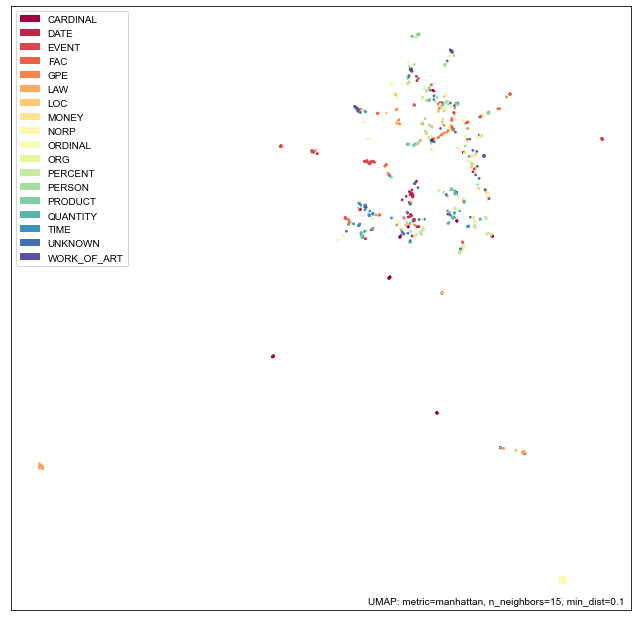

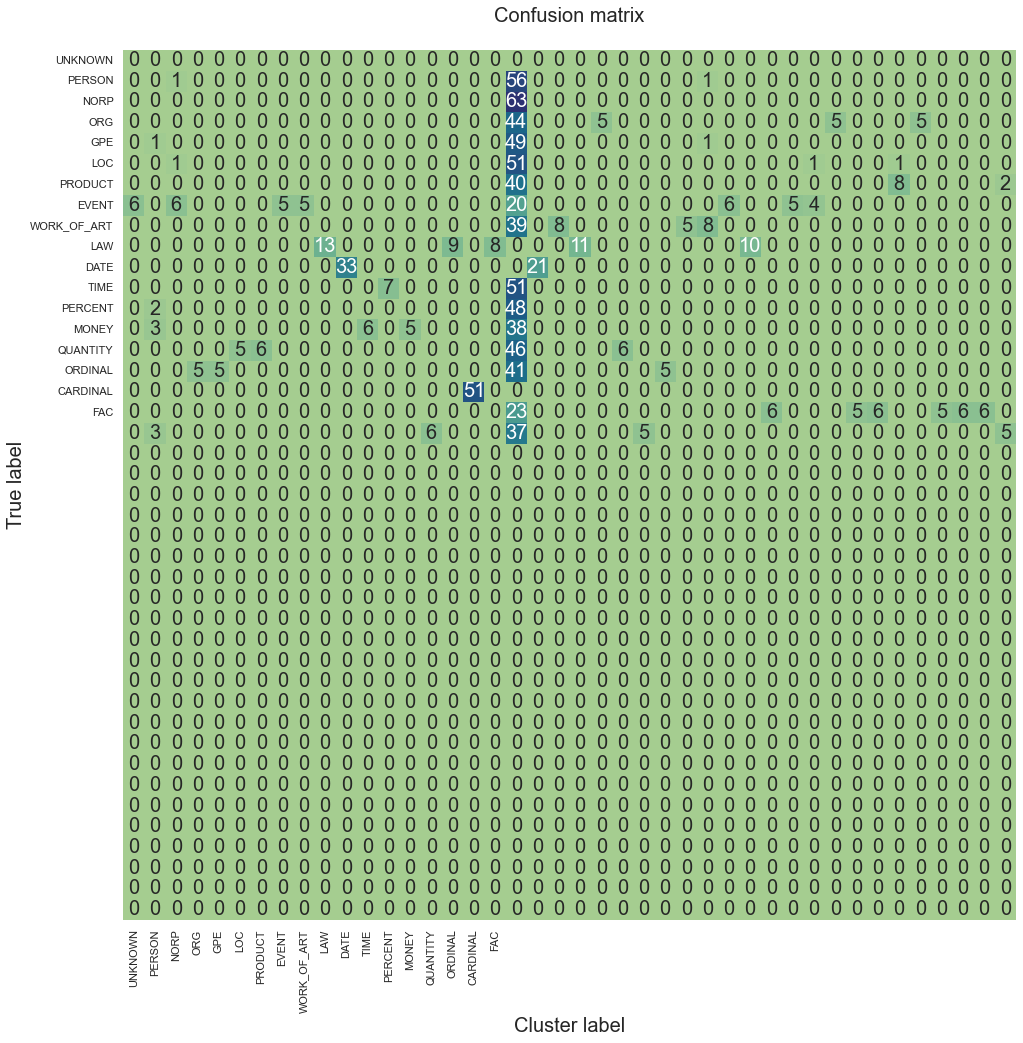



F1 score (weighted) = 0.8118
Accuracy = 0.8450
Precision = 0.8028
Recall = 0.8450
0: "UNK-4 Was QUANTITY", 5 items, (100.00% confidence)
NER Cluster 0 UNK-4 Was QUANTITY
5 items
1: "UNK-7 Was PRODUCT", 5 items, (100.00% confidence)
NER Cluster 1 UNK-7 Was PRODUCT
5 items
2: "UNK-8 Was PRODUCT", 5 items, (100.00% confidence)
NER Cluster 2 UNK-8 Was PRODUCT
5 items
3: "UNK-13 Was PERCENT", 5 items, (100.00% confidence)
NER Cluster 3 UNK-13 Was PERCENT
5 items
4: "UNK-15 Was FAC", 5 items, (100.00% confidence)
NER Cluster 4 UNK-15 Was FAC
5 items
5: "UNK-16 Was WORK_OF_ART", 9 items, (100.00% confidence)
NER Cluster 5 UNK-16 Was WORK_OF_ART
9 items
6: "UNK-17 Was WORK_OF_ART", 8 items, (100.00% confidence)
NER Cluster 6 UNK-17 Was WORK_OF_ART
8 items
7: "UNK-19 Was WORK_OF_ART", 11 items, (100.00% confidence)
NER Cluster 7 UNK-19 Was WORK_OF_ART
11 items
8: "UNK-21 Was MONEY", 6 items, (100.00% confidence)
NER Cluster 8 UNK-21 Was MONEY
6 items
9: "UNK-23 Was QUANTITY", 5 items, (100.00

In [ ]:
tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-10k-OPTICS',
    {
        'train_size':10000,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "OPTICS"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model(sample_size=1000)

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Load Data
Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Loaded file: 6267 samples
Data balance:
[[   2 1454]
 [   3  102]
 [   4 1344]
 [   5 1842]
 [   6   80]
 [  12 1100]
 [  13  101]
 [  14   96]
 [  15   73]
 [  16   75]]
Balancing data
Post Oversampling
x: (18420, 768), y: (18420,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 1/300
72/72 [==============================] - 1s 6ms/step - loss: 0.1034
Epoch 2/300
72/72 [==========

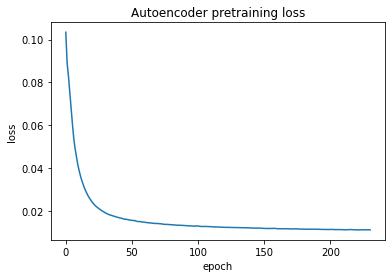

Iter:0 -> loss:0
Iter:140 -> loss:0.018023015931248665
Iter:280 -> loss:0.015454163774847984


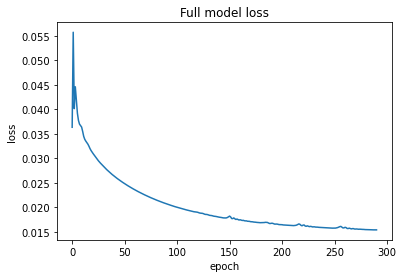

Training Done
Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Loading AE weights from ./results/test-latent-10k-agg\ae_weights.h5
Loading model weights from ./results/test-latent-10k-agg\lat_model_final.h5
Load Data
Test Data Loaded
Predicting...4 batches of 256


  0%|          | 0/4 [00:00<?, ?it/s]

Clustering 1000 points
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 15:30:31 2022 Construct fuzzy simplicial set
Sat Aug 27 15:30:32 2022 Finding Nearest Neighbors
Sat Aug 27 15:30:33 2022 Finished Nearest Neighbor Search
Sat Aug 27 15:30:34 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 15:30:35 2022 Finished embedding
CLUSTERS


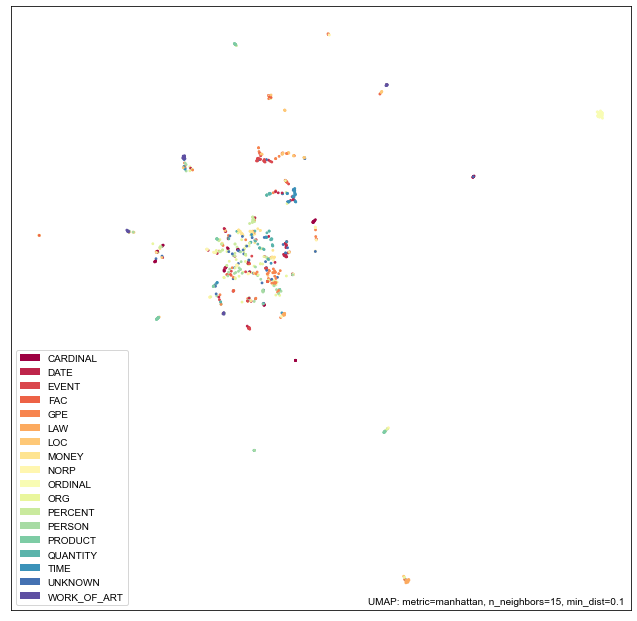

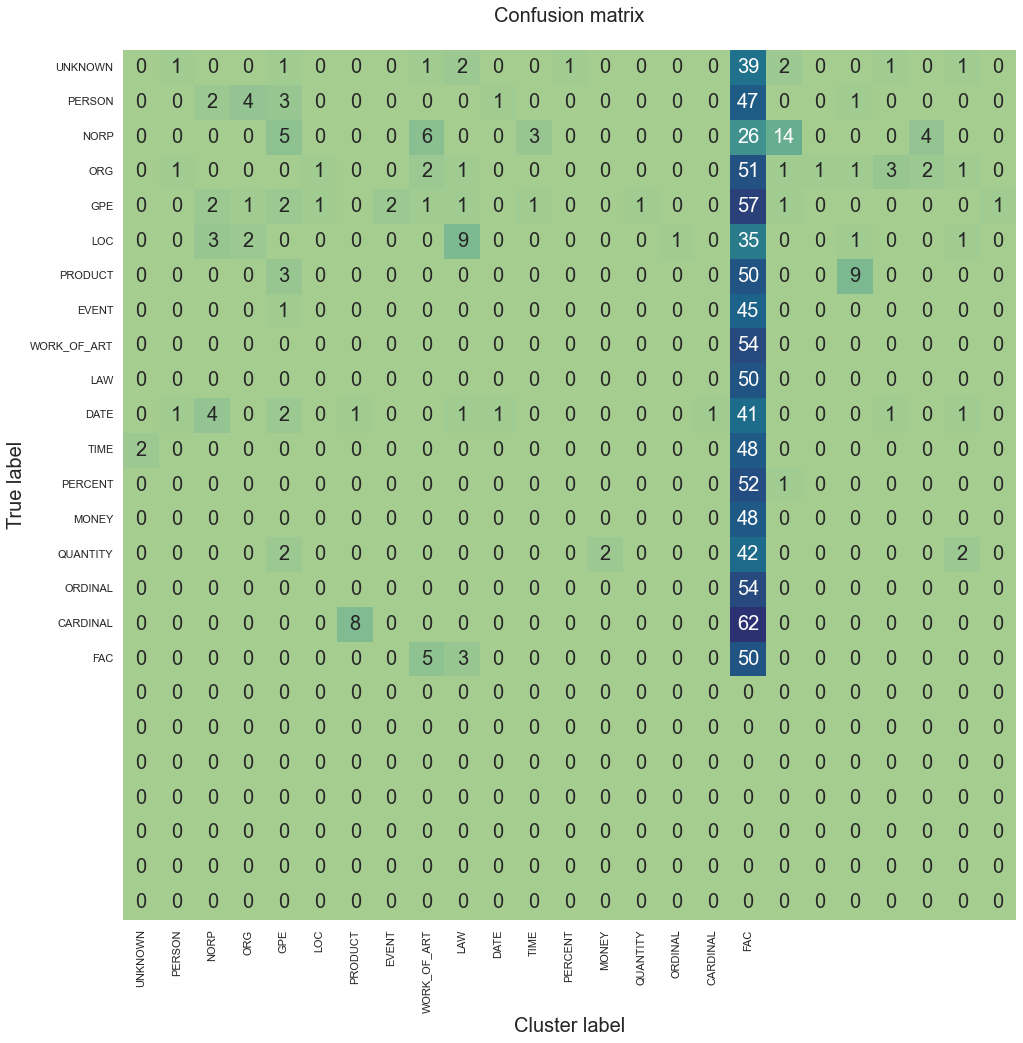



F1 score (weighted) = 0.5984
Accuracy = 0.6370
Precision = 0.5938
Recall = 0.6370
NER Cluster 0 UNK-15 Was GPE
1 items
NER Cluster 1 UNK-16 Was LOC
1 items
NER Cluster 2 UNK-17 Was DATE
1 items
NER Cluster 3 UNK-18 Was ORG
1 items
NER Cluster 4 UNK-23 Was GPE
1 items
NER Cluster 5 UNK-7 Was CARDINAL
9 items
NER Cluster 6 UNK-12 Was NORP
4 items
NER Cluster 7 UNK-21 Was NORP
6 items
NER Cluster 8 UNK-11 Was PERSON
2 items
NER Cluster 9 UNK-9 Was NORP
15 items
NER Cluster 10 UNK-22 Was QUANTITY
6 items
NER Cluster 11 UNK-5 Was NORP
19 items
NER Cluster 12 UNK-2
3 items
NER Cluster 13 UNK-13
1 items
NER Cluster 14 GPE
2 items
NER Cluster 15 QUANTITY
2 items
NER Cluster 16 TIME
2 items
NER Cluster 17 PRODUCT
12 items
NER Cluster 18 NORP
19 items
NER Cluster 19 ORG
5 items
NER Cluster 20 PERSON
7 items
NER Cluster 21 LOC
17 items
NER Cluster 22 DATE
11 items
NER Cluster 23 CARDINAL
851 items
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-10k-agg\ind

In [13]:
tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-10k-agg',
    {
        'train_size':10000,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "agg"
    })
dc.make_model()
dc.train_model()
dc.evaluate_model(sample_size=1000)

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Load Data
Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Loaded file: 6267 samples
Data balance:
[[   2 1454]
 [   3  102]
 [   4 1344]
 [   5 1842]
 [   6   80]
 [  12 1100]
 [  13  101]
 [  14   96]
 [  15   73]
 [  16   75]]
Balancing data
Post Oversampling
x: (18420, 768), y: (18420,)
{0: 'PERSON', 1: 'NORP', 2: 'ORG', 3: 'GPE', 4: 'LOC', 5: 'DATE', 6: 'TIME', 7: 'PERCENT', 8: 'MONEY', 9: 'QUANTITY'}
Data Loaded
Data Loaded
Training autoencoder
Epoch 1/300
72/72 [==============================] - 1s 5ms/step - loss: 0.1054
Epoch 2/300
72/72 [==========

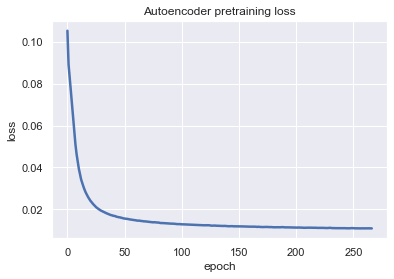

Iter:0 -> loss:0
Iter:140 -> loss:0.019100675359368324
Iter:280 -> loss:0.01594526693224907


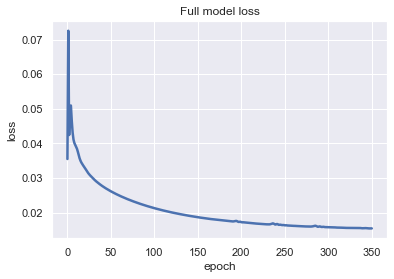

Training Done
Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Loading AE weights from ./results/test-latent-10k-GMM\ae_weights.h5
Loading model weights from ./results/test-latent-10k-GMM\lat_model_final.h5
Load Data
Test Data Loaded
Predicting...12 batches of 256


  0%|          | 0/12 [00:00<?, ?it/s]

Clustering 3000 points
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 15:31:56 2022 Construct fuzzy simplicial set
Sat Aug 27 15:32:02 2022 Finding Nearest Neighbors
Sat Aug 27 15:32:02 2022 Finished Nearest Neighbor Search
Sat Aug 27 15:32:02 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 15:32:07 2022 Finished embedding
CLUSTERS


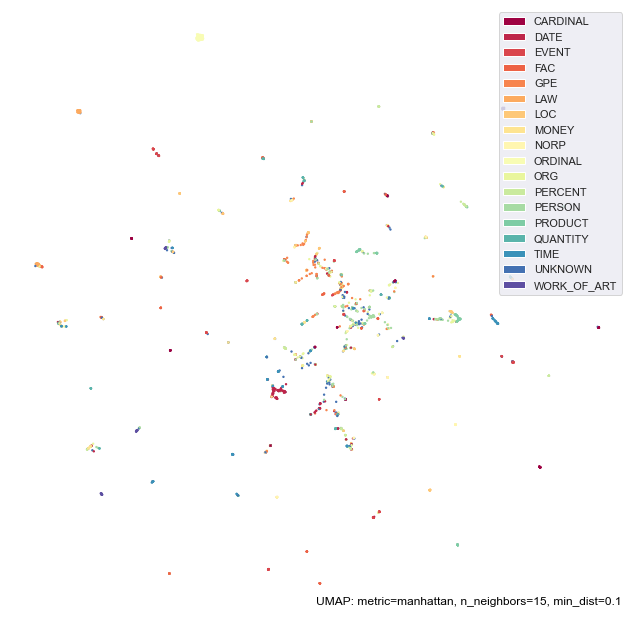

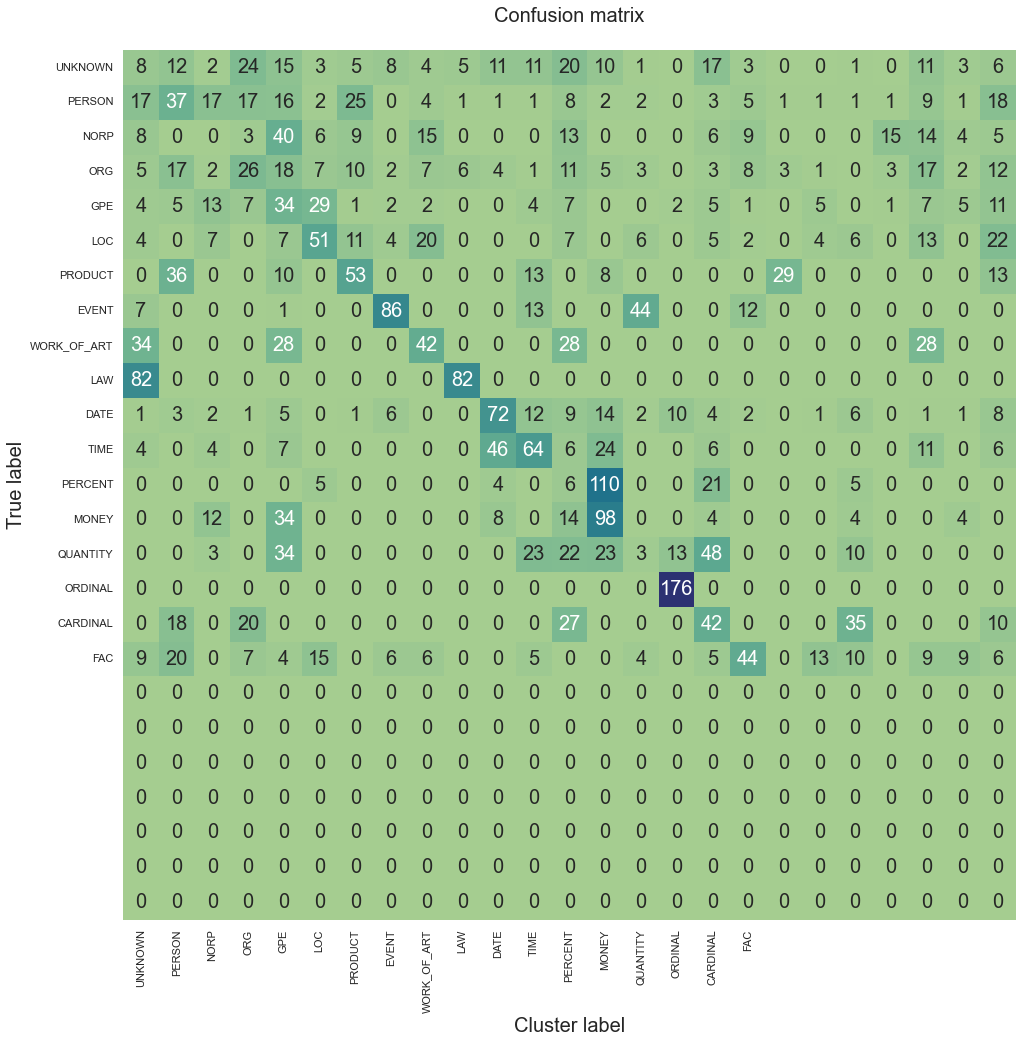



F1 score (weighted) = 0.8640
Accuracy = 0.8923
Precision = 0.8538
Recall = 0.8923
NER Cluster 0 UNK-20 Was NORP
20 items
NER Cluster 1 UNK-14 Was LAW
183 items
NER Cluster 2 UNK-22 Was FAC
29 items
NER Cluster 3 UNK-17 Was WORK_OF_ART
120 items
NER Cluster 4 UNK-23 Was LOC
117 items
NER Cluster 5 UNK-1 Was WORK_OF_ART
178 items
NER Cluster 6 ORDINAL
201 items
NER Cluster 7 LAW
94 items
NER Cluster 8 EVENT
114 items
NER Cluster 9 FAC
86 items
NER Cluster 10 DATE
146 items
NER Cluster 11 PRODUCT
115 items
NER Cluster 12 CARDINAL
78 items
NER Cluster 13 TIME
147 items
NER Cluster 14 LOC
118 items
NER Cluster 15 WORK_OF_ART
100 items
NER Cluster 16 PERCENT
294 items
NER Cluster 17 QUANTITY
169 items
NER Cluster 18 PERSON
148 items
NER Cluster 19 ORG
105 items
NER Cluster 20 NORP
253 items
... wrote results  <a href="c:\Users\Will\Projects\MSc\project\src\results\test-latent-10k-GMM\index.html">c:\Users\Will\Projects\MSc\project\src\results\test-latent-10k-GMM\index.html</a>


In [14]:
tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-10k-GMM',
    {
        'train_size':10000,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })
dc.make_model()
dc.train_model()
dc.evaluate_model(sample_size=3000)

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Loading AE weights from ./results/test-latent-10k-kmeans\ae_weights.h5
Loading model weights from ./results/test-latent-10k-kmeans\lat_model_final.h5
Load Data
Test Data Loaded
Predicting...12 batches of 256


  0%|          | 0/12 [00:00<?, ?it/s]

Clustering 3000 points
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 15:16:18 2022 Construct fuzzy simplicial set
Sat Aug 27 15:16:23 2022 Finding Nearest Neighbors
Sat Aug 27 15:16:23 2022 Finished Nearest Neighbor Search
Sat Aug 27 15:16:23 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 15:16:27 2022 Finished embedding
CLUSTERS


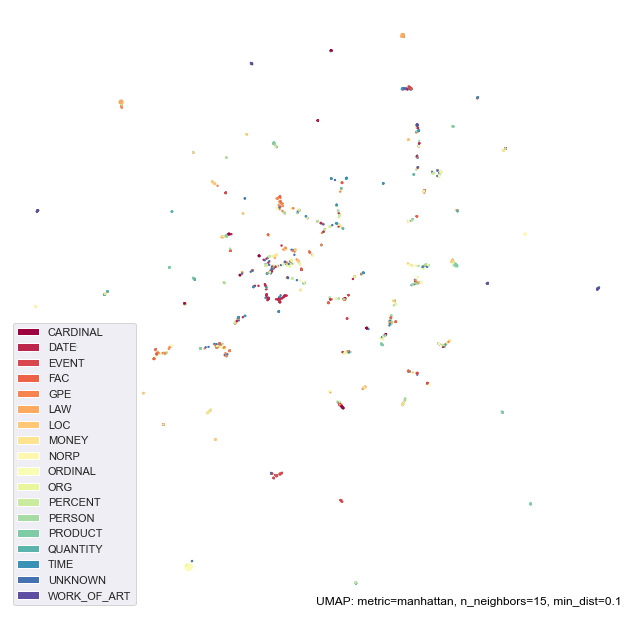

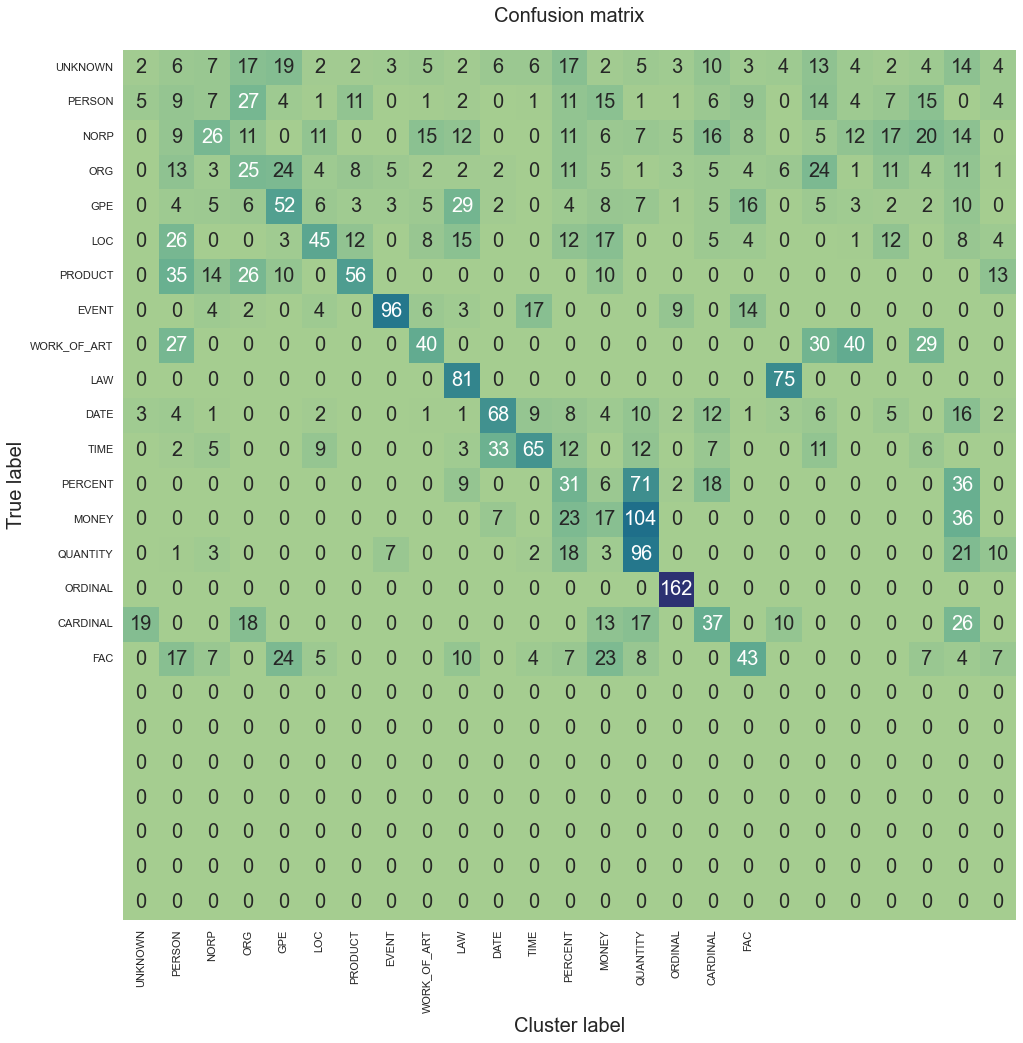



F1 score (weighted) = 0.8605
Accuracy = 0.8880
Precision = 0.8516
Recall = 0.8880
0: "UNK-15 Was LAW", 98 items, (76.53% confidence)
NER Cluster 0 UNK-15 Was LAW
98 items
1: "UNK-24 Was CARDINAL", 29 items, (65.52% confidence)
NER Cluster 1 UNK-24 Was CARDINAL
29 items
2: "UNK-19 Was WORK_OF_ART", 65 items, (61.54% confidence)
NER Cluster 2 UNK-19 Was WORK_OF_ART
65 items
3: "UNK-20 Was NORP", 56 items, (30.36% confidence)
NER Cluster 3 UNK-20 Was NORP
56 items
4: "UNK-23 Was PRODUCT", 45 items, (28.89% confidence)
NER Cluster 4 UNK-23 Was PRODUCT
45 items
5: "ORDINAL", 188 items, (86.17% confidence)
NER Cluster 5 ORDINAL
188 items
6: "EVENT", 114 items, (84.21% confidence)
NER Cluster 6 EVENT
114 items
7: "TIME", 104 items, (62.50% confidence)
NER Cluster 7 TIME
104 items
8: "PRODUCT", 92 items, (60.87% confidence)
NER Cluster 8 PRODUCT
92 items
9: "DATE", 118 items, (57.63% confidence)
NER Cluster 9 DATE
118 items
10: "LOC", 89 items, (50.56% confidence)
NER Cluster 10 LOC
89 items

In [13]:
tf.get_logger().setLevel('ERROR')

dc = None
dc = DeepLatentCluster(
    'test-latent-10k-kmeans',
    {
        'train_size':1000,
        'reconstr_weight':1.0,
        'latent_weight':1e-5,
        "cluster": "Kmeans"
    })
# dc.make_model()
# dc.train_model()
dc.evaluate_model(sample_size=3000)

In [ ]:
tf.get_logger().setLevel('ERROR')

dc = DeepLatentCluster(
        'test-latent', 
        {
          'train_size':1000,
          'reconstr_weight':1.0, 'latent_weight':1e-5
        })
dc.make_model()
print(dc.autoencoder.summary())

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Model: "ae-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               384500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 40)                80040     
                                                                 

In [ ]:

dc.evaluate_model(1000, sample_size=1000)

NameError: name 'dc' is not defined

In [28]:
tf.get_logger().setLevel('ERROR')

dc = DeepLatentCluster(
    'test-latent-10k',
    {
        'train_size':10000,
        'reconstr_weight':1.0, 'latent_weight':1e-5
    })
dc.make_model()
# dc.train_model()


Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled


Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled
Loading AE weights from ./results/test-latent-10k-kmeans\ae_weights.h5
Loading model weights from ./results/test-latent-10k-kmeans\lat_model_final.h5
Predicting...


  0%|          | 0/184 [00:00<?, ?it/s]

Clustering 1000 points
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 14:08:01 2022 Construct fuzzy simplicial set
Sat Aug 27 14:08:01 2022 Finding Nearest Neighbors
Sat Aug 27 14:08:01 2022 Finished Nearest Neighbor Search
Sat Aug 27 14:08:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 14:08:04 2022 Finished embedding
CLUSTERS


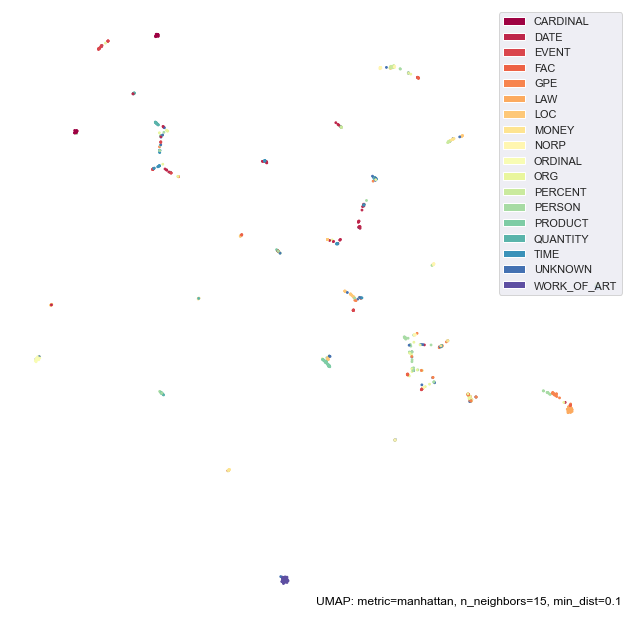

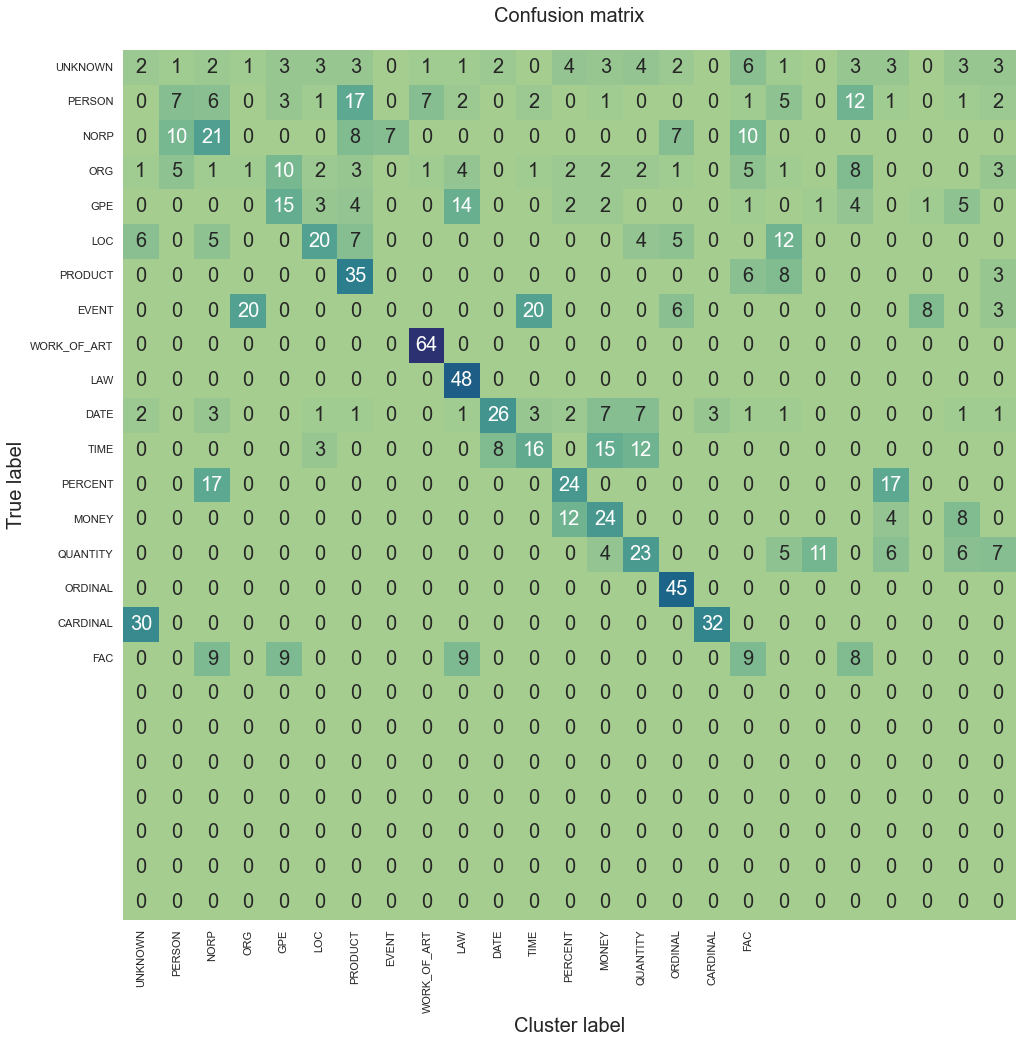



F1 score (weighted) = 0.8186
Accuracy = 0.8490
Precision = 0.8109
Recall = 0.8490
0: "UNK-11 Was NORP", 7 items, (100.00% confidence)
NER Cluster 0 UNK-11 Was NORP
7 items
1: "UNK-12 Was EVENT", 22 items, (90.91% confidence)
NER Cluster 1 UNK-12 Was EVENT
22 items
2: "UNK-21 Was EVENT", 9 items, (88.89% confidence)
NER Cluster 2 UNK-21 Was EVENT
9 items
3: "UNK-16 Was CARDINAL", 41 items, (73.17% confidence)
NER Cluster 3 UNK-16 Was CARDINAL
41 items
4: "UNK-14 Was PERCENT", 31 items, (54.84% confidence)
NER Cluster 4 UNK-14 Was PERCENT
31 items
5: "UNK-15 Was NORP", 23 items, (43.48% confidence)
NER Cluster 5 UNK-15 Was NORP
23 items
6: "UNK-17 Was LOC", 33 items, (36.36% confidence)
NER Cluster 6 UNK-17 Was LOC
33 items
7: "UNK-5 Was MONEY", 24 items, (33.33% confidence)
NER Cluster 7 UNK-5 Was MONEY
24 items
8: "UNK-23 Was QUANTITY", 22 items, (31.82% confidence)
NER Cluster 8 UNK-23 Was QUANTITY
22 items
9: "UNK-22 Was NORP", 39 items, (25.64% confidence)
NER Cluster 9 UNK-22 Was

TemplateSyntaxError: expected token ':', got '}'

In [20]:
dc.evaluate_model(10000, sample_size=1000)

In [ ]:
stop

In [12]:
tf.get_logger().setLevel('ERROR')

dc = DeepLatentCluster(
    'test-latent-all-10ent',
    {
        'entity_count': 10,
        'train_size':0,
        'reconstr_weight':1.0, 'latent_weight':1e-5
    })
dc.make_model()
# dc.train_model()

Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500 activation=None
Layer latent_2: 500 activation=None
Layer latent_out: 2000 activation=sigmoid
model compiled


In [13]:
dc.evaluate_model(10000, sample_size=1000)

Load Data
Loading ./data/conll_spacy_10000_test.pkl
LOADED {1: 'UNKNOWN', 2: 'PERSON', 4: 'ORG', 5: 'GPE', 11: 'DATE', 12: 'TIME', 8: 'EVENT', 16: 'ORDINAL', 3: 'NORP', 14: 'MONEY', 15: 'QUANTITY', 18: 'FAC', 6: 'LOC', 7: 'PRODUCT', 10: 'LAW', 9: 'WORK_OF_ART', 17: 'CARDINAL', 13: 'PERCENT'}
Loaded file: 12479 samples
Data balance:
[[    1 10305]
 [    2   404]
 [    3    24]
 [    4   439]
 [    5   668]
 [    6    44]
 [    7    14]
 [    8    24]
 [    9     5]
 [   10     2]
 [   11   380]
 [   12    31]
 [   13    38]
 [   14    30]
 [   15    29]
 [   16     1]
 [   17    15]
 [   18    26]]
Balancing data
Post Oversampling
x: (185490, 768), y: (185490,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LAW', 10: 'DATE', 11: 'TIME', 12: 'PERCENT', 13: 'MONEY', 14: 'QUANTITY', 15: 'ORDINAL', 16: 'CARDINAL', 17: 'FAC'}
Test Data Loaded
Autoencoder
Latent Model
Layer latent_0: 2000 activation=None
Layer latent_1: 500

  0%|          | 0/724 [00:00<?, ?it/s]

Clustering 1000 points
Initialization 0
Initialization converged: True	 time lapse 19.37085s	 ll 11881.56552
Visualising
UMAP(metric='manhattan', verbose=True)
Sat Aug 27 10:53:04 2022 Construct fuzzy simplicial set
Sat Aug 27 10:53:05 2022 Finding Nearest Neighbors
Sat Aug 27 10:53:07 2022 Finished Nearest Neighbor Search
Sat Aug 27 10:53:09 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Sat Aug 27 10:53:11 2022 Finished embedding
CLUSTERS


# benchmark

In [ ]:
# optimal eps https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

from sklearn.neighbors import NearestNeighbors

def optimal_eps(X, n_neighbors=10):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [ ]:
def cluster_score(y, y_pred, n_clusters):
    """
    Compute the cluster score.
    Arguments:
        y: true labels.
        y_pred: predicted labels.
        n_clusters: number of clusters.
    Returns:
        cluster score.
    """
    # compute the cluster score
    score = 0
    for i in range(n_clusters):
        score += np.sum(y_pred[y==i]==i)
    return score/len(y)

In [ ]:
def hypertune_density_clustering():
    """
    hypertune the density clustering algorithms.
    """
    eps_vals = [30000.0, 40000.0, 50000.0]
    x, y, mapping, strings = load_data(
                                    1000,
                                    oversample=True,
                                    get_text=True)
    print(f"Optimal epsilon: {optimal_eps(x)}")
    for eps in eps_vals:
        # predict cluster labels
        print(f"Predicting...for epsilon={eps}")
        y_pred, _ = do_clustering('DBSCAN', 25, x, params={'eps':eps})
        print(f"ACC: {cluster_score(y, y_pred, 25)}")
        # confusion matrix
        cm_width = max(8, len(np.unique(y_pred)) * 2)
        cm_width = min(16, cm_width)
        plot_confusion(y, y_pred, mapping, size=cm_width, save_dir=None, details=False)

In [ ]:
hypertune_density_clustering()

In [ ]:
def run_benchmark(cluster:str, eval_size:int, n_clusters:int):
    x, y, mapping, strings = load_data(
                                    eval_size,
                                    oversample=False,
                                    get_text=True)
    save_dir = f'./results/bm/{cluster}'
    if not os.path.exists(save_dir):
        # create save dir
        os.makedirs(save_dir)

    
    # predict cluster labels
    print("Predicting...")
    y_pred, _ = do_clustering(cluster, n_clusters, x)
    # print(f"ACC: {cluster_acc(y, y_pred)}")
    
    # confusion matrix
    cm_width = max(8, len(np.unique(y_pred)) * 2)
    cm_width = min(16, cm_width)
    plot_confusion(y, y_pred, mapping, save_dir, cm_width)

    # show wordclouds for each cluster
    print ("BENCHMARK CLUSTERS")
    clusters = {}
    predicted = DataFrame({'text':strings, 'y_pred':y_pred, 'y_true':y})
    for cluster_no in range(n_clusters):
        y_pred_for_key = predicted[predicted['y_pred']==cluster_no]
        true_label = 'UNKNOWN'
        modal_value = y_pred_for_key['y_true'].mode()
        if len(modal_value)>0:
            if modal_value[0] in mapping:
                true_label = mapping[modal_value[0]]
            # confidence - fraction of this cluster that is actually this cluster
            y_true_this_cluster = len(
                y_pred_for_key[y_pred_for_key['y_true']==modal_value[0]])
            frac = y_true_this_cluster/len(y_pred_for_key)
        else:
            frac = 0

        # wordcloud
        unique, counts = np.unique(y_pred_for_key['text'], return_counts=True)
        freq_list = np.asarray((unique, counts)).T
        freq_list =  sorted(freq_list, key=lambda x: -x[1])[0:50]
        freqs = {w: f for w,f in freq_list}
        entry = {'freqs':freqs, 'frac':frac, 'n':len(y_pred_for_key)}
        if true_label == 'UNKNOWN':
            clusters[f"UNK-{cluster_no}"] = entry
        elif true_label in clusters:
            if clusters[true_label]['frac'] < frac:
                # we found a better cluster for this label
                clusters[true_label] = entry
            else:
                # this cluster is worse than this one, so it's unknown
                clusters[f"UNK-{cluster_no} Was {true_label}"] = entry
        else:
            clusters[true_label] = entry

    cluster_list = [{
        **clusters[c],
        'name': c,
        'idx': idx} for idx, c in enumerate(clusters)]
    cluster_list = sorted(cluster_list, key=lambda x: -x['frac'])

    display_list = []
    # show unknown clusters first
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] == "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    # next show known clusters
    for i, cluster in enumerate(cluster_list):
        if cluster['name'][0:3] != "UNK":
            save_file = os.path.join(save_dir,
                                     f"wordcloud-{cluster['name']}.png")
            show_wordcloud(i, cluster, save_file, save_only=True)
            display_list.append(cluster)

    
    print(write_results_page(display_list, save_dir, cluster))

Loading ./data/conll_spacy_10000.pkl
LOADED {1: 'UNKNOWN', 4: 'ORG', 2: 'PERSON', 12: 'DATE', 5: 'GPE', 6: 'LOC', 16: 'QUANTITY', 14: 'PERCENT', 8: 'EVENT', 15: 'MONEY', 3: 'NORP', 17: 'ORDINAL', 19: 'FAC', 13: 'TIME', 18: 'CARDINAL', 7: 'PRODUCT', 10: 'LANGUAGE', 9: 'WORK_OF_ART', 11: 'LAW'}
Loaded file: 37748 samples
Data balance:
[[    1 31291]
 [    2  1454]
 [    3   102]
 [    4  1344]
 [    5  1842]
 [    6    80]
 [    7    21]
 [    8    32]
 [    9     8]
 [   10     5]
 [   11     5]
 [   12  1100]
 [   13   101]
 [   14    96]
 [   15    73]
 [   16    75]
 [   17     6]
 [   18    44]
 [   19    69]]
x: (37748, 768), y: (37748,)
{0: 'UNKNOWN', 1: 'PERSON', 2: 'NORP', 3: 'ORG', 4: 'GPE', 5: 'LOC', 6: 'PRODUCT', 7: 'EVENT', 8: 'WORK_OF_ART', 9: 'LANGUAGE', 10: 'LAW', 11: 'DATE', 12: 'TIME', 13: 'PERCENT', 14: 'MONEY', 15: 'QUANTITY', 16: 'ORDINAL', 17: 'CARDINAL', 18: 'FAC'}
Predicting...


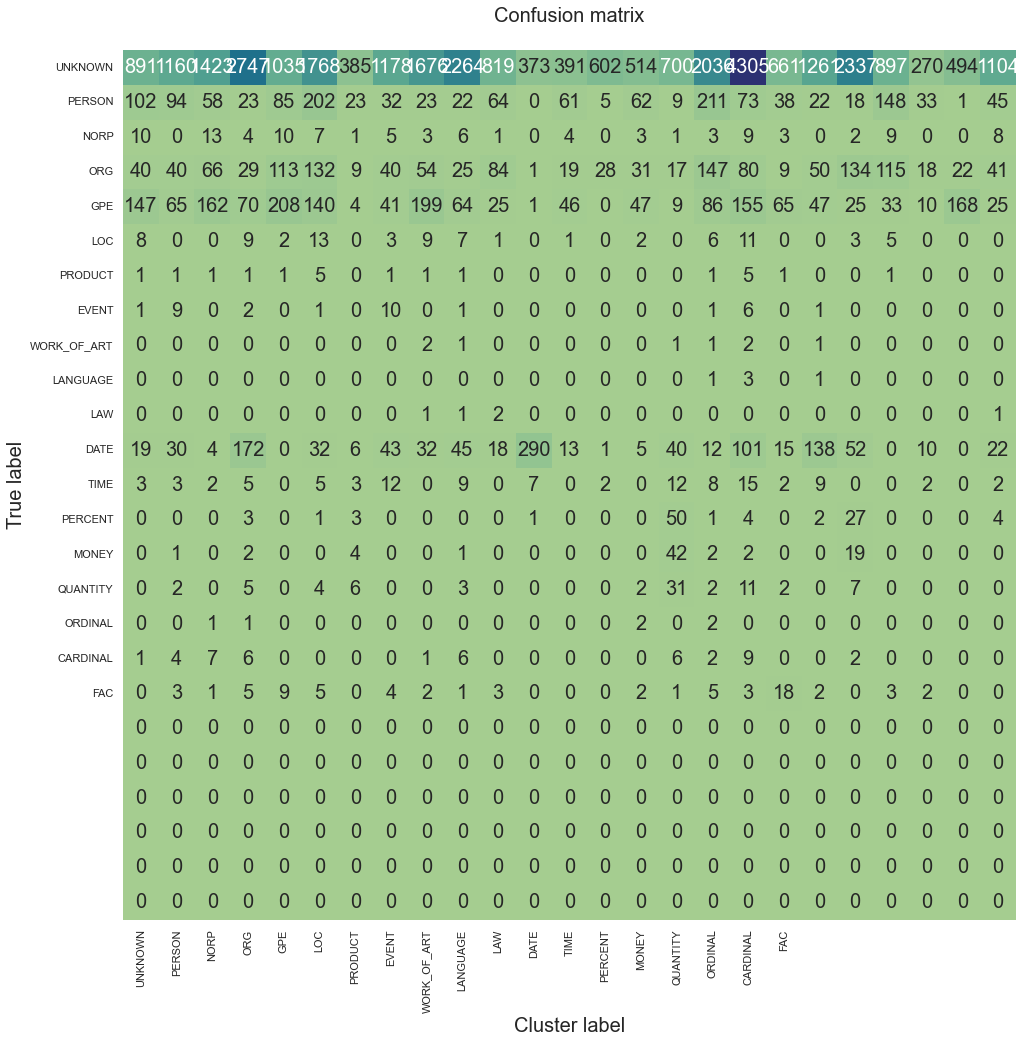

BENCHMARK CLUSTERS


TypeError: show_wordcloud() missing 3 required positional arguments: 'name', 'filepath', and 'n'

In [14]:
run_benchmark('Kmeans', 10000, 25)

In [ ]:
run_benchmark('GMM', 10000, 25)

In [ ]:
run_benchmark('agg', 10000, 25)